# Imports

In [20]:
import ipydeps
ipydeps.pip('matplotlib')
ipydeps.pip('pandas')
ipydeps.pip('seaborn')
ipydeps.pip('numpy')
ipydeps.pip('datetime')
ipydeps.pip('sklearn')
ipydeps.pip('imblearn')
ipydeps.pip('statsmodels')
ipydeps.pip('pyMC3')

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm

import pymc3 as pm
import arviz as az

# Datasets

## Dataset 1 - Unlabed User Data

In [2]:
# Reading in the dataset of unlabeled user data with the appropriate encoding
df = pd.read_csv('users.csv',encoding = "ISO-8859-1")
df = df.fillna(0)
df.head()

,index,account_id,handle,name,description,url,language,location,account_created_at,account_created_at_interpolated,...,following_count,statuses_count,listed_count,last_post_id,last_post_text,last_post_lat,last_post_lon,last_post_place_id,last_post_created_at,time_since_last_post
0,226332,32633,diavolorosso,pierop,0,0,en,0,11/30/2006 18:07,11/30/2006 18:07,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
1,223719,32658,0,0,0,0,0,0,0,11/30/2006 18:22,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
2,638926,34234,0,0,0,0,0,0,0,12/1/2006 10:39,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
3,443712,35250,0,0,0,0,0,0,0,12/1/2006 21:09,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
4,210999,36155,0,0,0,0,0,0,0,12/2/2006 6:31,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0


In [3]:
# Narrowing down the dataset of unlabeled user data to only those records with missing == 0, as 
# if missing=1, the account never existed, and
# if missing=2, the only field populated is account_created_at_interpolated, and all other counts are 0, so it is not useful

df2 = df[(df['missing']==0)]
df2['days_since_creation'] = (pd.to_datetime(df2['crawled_at'], format='%m/%d/%Y %H:%M') - pd.to_datetime(df2['account_created_at'], format='%m/%d/%Y %H:%M')).dt.days
df2.head()

C:\Users\Marisa\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,index,account_id,handle,name,description,url,language,location,account_created_at,account_created_at_interpolated,...,statuses_count,listed_count,last_post_id,last_post_text,last_post_lat,last_post_lon,last_post_place_id,last_post_created_at,time_since_last_post,days_since_creation
0,226332,32633,diavolorosso,pierop,0,0,en,0,11/30/2006 18:07,11/30/2006 18:07,...,0.0,0.0,0.000000e+00,0,0.0,0.0,0,0,0.000000,2494
13,54078,58633,huge,huge,"Most blocked on Twitter #mbot, got @GodKinCoun...",http://t.co/6PnvTuysyt,en,PST,12/11/2006 22:49,12/11/2006 22:49,...,12823.0,72.0,3.793160e+17,Sleeping in the sunroom. http://t.co/VCcNOm81yt,0.0,0.0,0,9/15/2013 18:48,109.818889,2474
14,202969,60453,jmeyer43,John Meyer,Sr. .NET developer for Disney Vacation Club. F...,http://t.co/aFMzKKJMHR,en,"Orlando, Florida, USA",12/12/2006 13:25,12/12/2006 13:25,...,515.0,9.0,3.717700e+17,".@12willpower no offense dude, I'm a fan, but ...",0.0,0.0,0,8/25/2013 23:04,784.541667,2481
16,26537,72373,frankarr,Frank Arrigo,"Aussie Geek, Returned home from the Pacific No...",http://t.co/BiiySVcGR1,en,"Brighton, Victoria, Australia",12/15/2006 22:18,12/15/2006 22:18,...,16282.0,166.0,3.804680e+17,Daily Fitbit stats: My fitbit #Fitstats_AU for...,0.0,0.0,0,9/18/2013 23:05,1.914722,2469
184,496131,658723,mcgyver,mcgyver SEO,Think Deep Sync Wide for Applying the known to...,0,en,God's Hotel,1/18/2007 4:18,1/18/2007 4:18,...,5991.0,25.0,3.831680e+17,í¼í ì ìì¼ë©´ ì¦ê¸°ë¼ê³ ? í¬ê¸°íê³...,0.0,0.0,0,9/26/2013 9:56,375.072778,2458


In [5]:
# Summarize the unlabeled user data
df2.describe()

,index,account_id,missing,protected,followers_count,following_count,statuses_count,listed_count,last_post_id,last_post_lat,last_post_lon,time_since_last_post,days_since_creation
count,292587.000000,2.925870e+05,292587.0,292587.000000,2.925870e+05,292587.000000,292587.000000,292587.000000,2.925870e+05,292587.000000,292587.000000,292587.000000,292587.000000
mean,326748.148267,6.603075e+08,0.0,0.053639,5.728738e+01,65.189359,414.562988,0.605721,1.330454e+17,0.130028,-0.031299,4569.433877,657.196256
std,189100.408949,4.924256e+08,0.0,0.225304,2.875773e+03,1085.443135,3225.874345,64.123240,1.585171e+17,2.512596,5.810338,8266.692377,446.302604
min,1.000000,3.263300e+04,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-53.149025,-157.859955,0.000000,16.000000
25%,162500.000000,2.557355e+08,0.0,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,280.000000
50%,326157.000000,5.121268e+08,0.0,0.000000,1.000000e+00,6.000000,1.000000,0.000000,4.977139e+09,0.000000,0.000000,2.807222,579.000000
75%,490684.000000,1.039459e+09,0.0,0.000000,8.000000e+00,31.000000,12.000000,0.000000,3.081760e+17,0.000000,0.000000,5787.902500,954.000000
max,655075.000000,1.717175e+09,0.0,1.000000,1.401143e+06,297082.000000,537516.000000,34157.000000,3.916590e+17,64.231000,151.627672,57074.331390,2494.000000


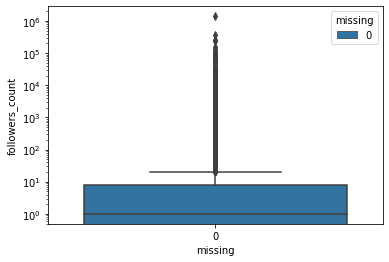

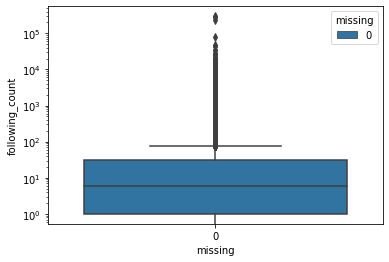

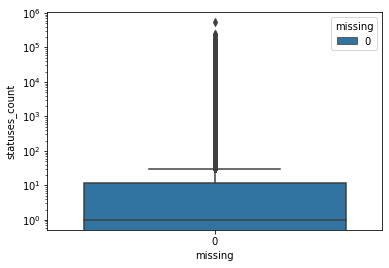

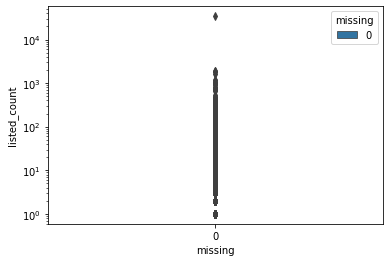

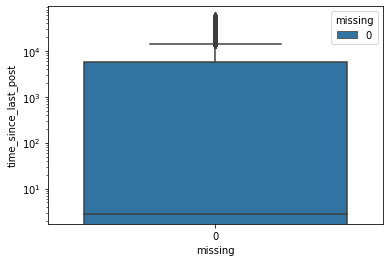

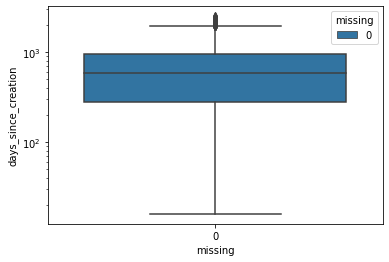

In [6]:
# The available columns are:
# account_created_at_interpolated (time since creation), 
# followers_count, following_count, statuses_count, listed_count, 
# last_post_created_at (time since last post) or time_since_last_post

# Create box and whisker plots for the unlabeled user data, using columns of potential interest
fig, ax = plt.subplots()
sns.boxplot(data=df2, y='followers_count', x='missing', hue='missing')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=df2, y='following_count', x='missing', hue='missing')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=df2, y='statuses_count', x='missing', hue='missing')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=df2, y='listed_count', x='missing', hue='missing')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=df2, y='time_since_last_post', x='missing', hue='missing')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=df2, y='days_since_creation', x='missing', hue='missing')
ax.set_yscale('log')

<AxesSubplot:xlabel='days_since_creation', ylabel='Count'>

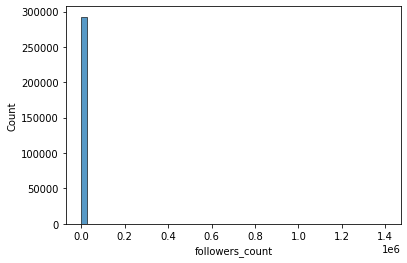

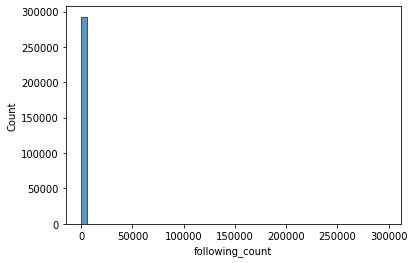

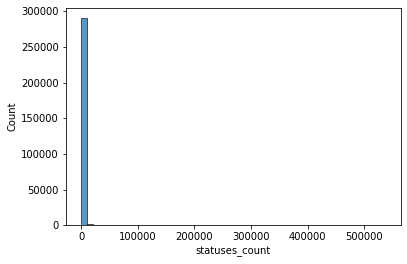

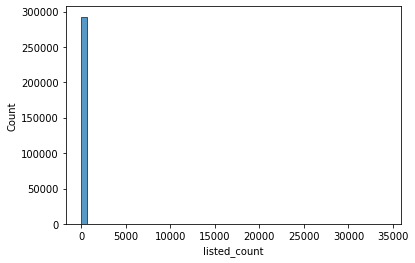

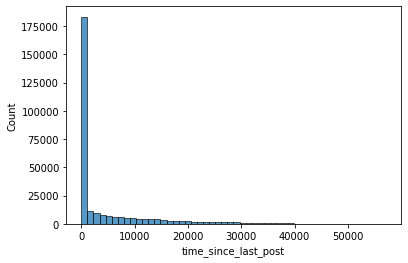

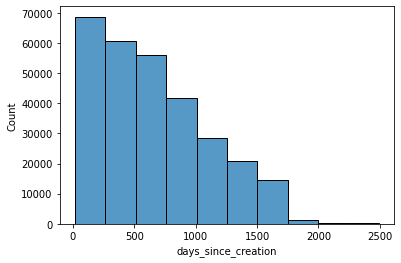

In [7]:
# Create histogram plots for the unlabeled user data, using columns of potential interest
fig, ax = plt.subplots()
sns.histplot(data=df2, x='followers_count', stat='count',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=df2, x='following_count', stat='count',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=df2, x='statuses_count', stat='count',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=df2, x='listed_count', stat='count',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=df2, x='time_since_last_post', stat='count',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=df2, x='days_since_creation', stat='count',bins=10)

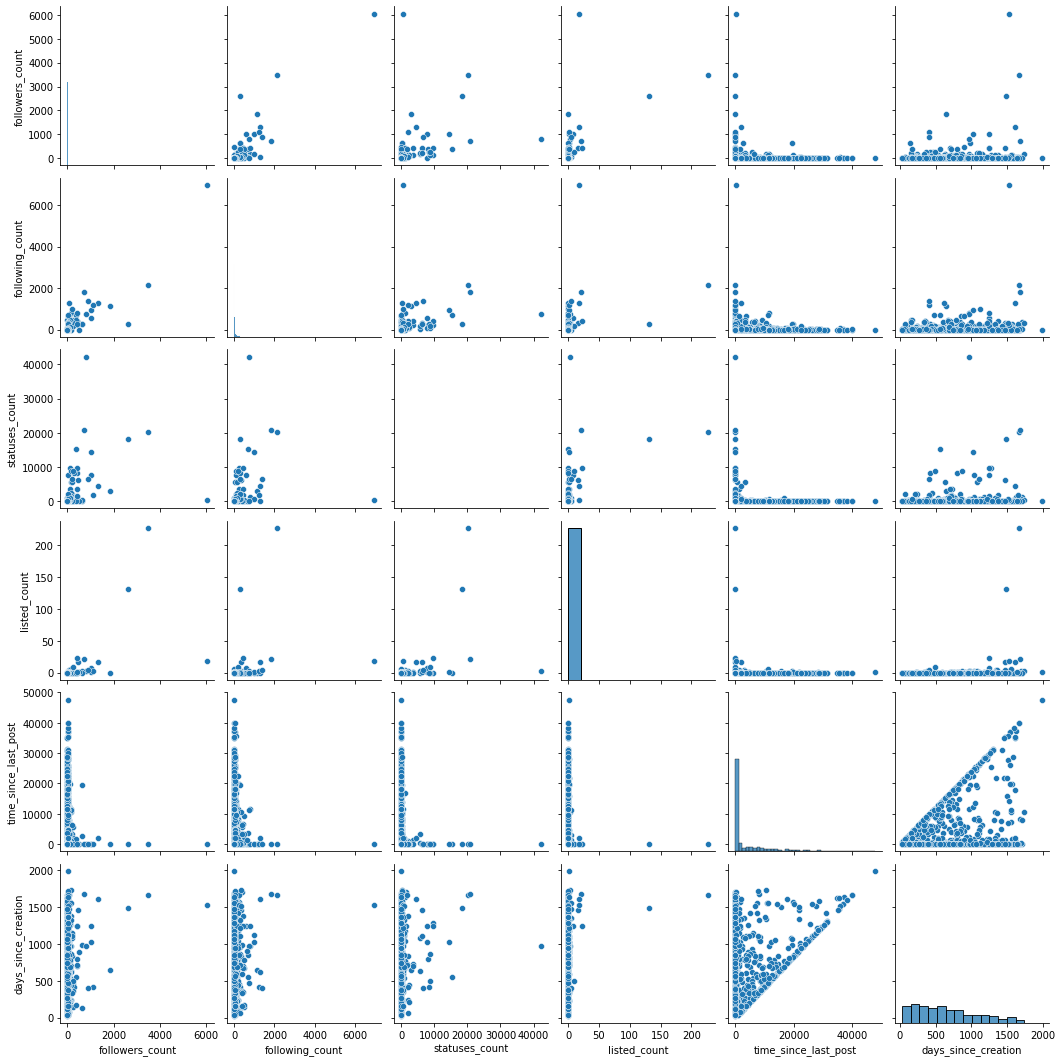

In [8]:
# Create pairwise scatterplots for the unlabeled user data, using columns of potential interest
sns.pairplot(data=df2[['followers_count','following_count','statuses_count','listed_count','time_since_last_post','days_since_creation']].sample(1000))

## Dataset 2 - Labeled "Book Tweets" Data

In [9]:
# Read in the labeled "Book Tweets" dataset with the appropriate encoding
newdf = pd.read_csv('TwitterData.csv',encoding = "ISO-8859-1")
newdf = newdf.rename(columns={"ï»¿Name": "Name"})
newdf['days_since_creation'] = (datetime.today() - pd.to_datetime(newdf['Joined'], format='%b-%y')).dt.days
newdf.head()

,Name,Following,Followers,Joined,TotTweets,CommentsMostRecent,RetweetsMostRecent,LikesMostRecent,Verified,days_since_creation
0,bookofthemonth,729,16500,Mar-09,4211,5,13,144,1,4634
1,randomhouse,3273,195200,Jul-07,46000,0,2,2,1,5243
2,BNBuzz,1613,263600,Apr-09,40200,6,38,124,1,4603
3,MissLiberty,4246,19900,Mar-08,63800,29,129,1000,0,4999
4,BerkleyRomance,2287,28300,Apr-11,21300,0,5,9,1,3873


In [22]:
# Summarize the "Book Tweets" dataset
newdf.describe()

,Following,Followers,TotTweets,CommentsMostRecent,RetweetsMostRecent,LikesMostRecent,Verified,days_since_creation
count,99.000000,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1770.222222,2.288745e+05,18716.757576,194.707071,3188.717172,16481.868687,0.212121,2993.191919
std,4977.571750,1.843970e+06,45938.528090,1253.023382,16441.960449,87274.972702,0.410891,1676.247587
min,3.000000,0.000000e+00,0.000000,-1.000000,-1.000000,-1.000000,0.000000,67.000000
25%,302.000000,5.200000e+01,212.000000,0.000000,0.000000,2.500000,0.000000,1513.000000
50%,729.000000,5.310000e+02,4211.000000,1.000000,4.000000,17.000000,0.000000,3385.000000
75%,1532.000000,8.210500e+03,17400.000000,18.500000,98.000000,283.500000,0.000000,4573.000000
max,42400.000000,1.830000e+07,404600.000000,12200.000000,137000.000000,805100.000000,1.000000,5365.000000


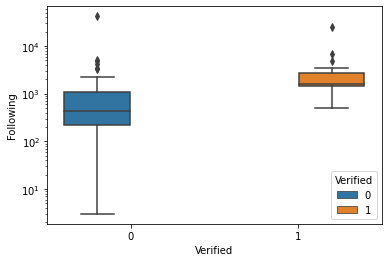

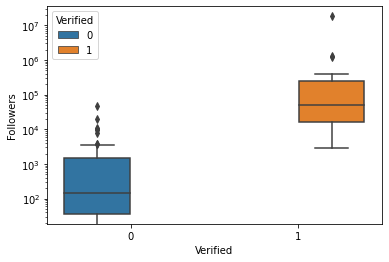

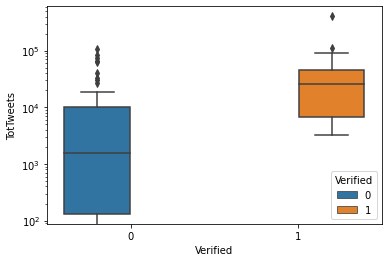

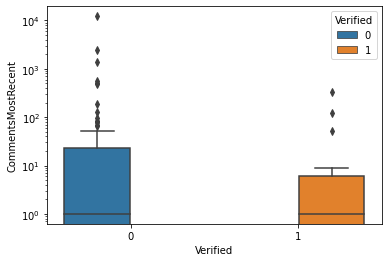

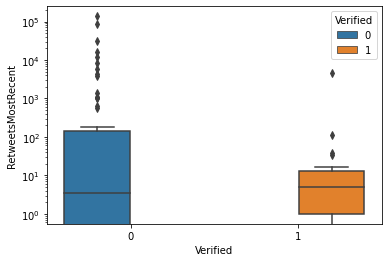

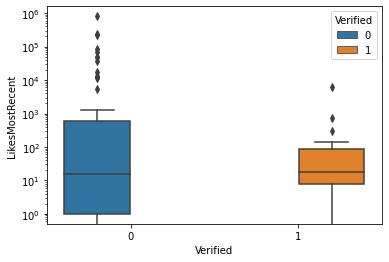

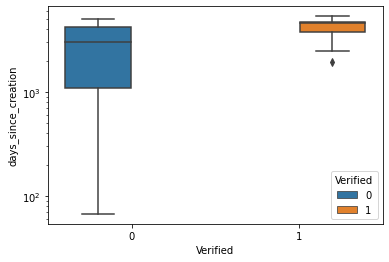

In [11]:
# Create box and whisker plots for the "Book Tweets" data, using columns of potential interest
fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='Following', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='Followers', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='TotTweets', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='CommentsMostRecent', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='RetweetsMostRecent', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='LikesMostRecent', x='Verified', hue='Verified')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=newdf, y='days_since_creation', x='Verified', hue='Verified')
ax.set_yscale('log')

<AxesSubplot:xlabel='days_since_creation', ylabel='Density'>

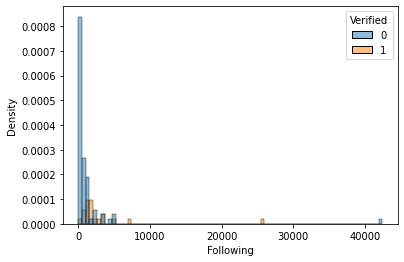

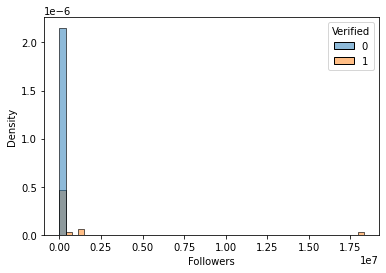

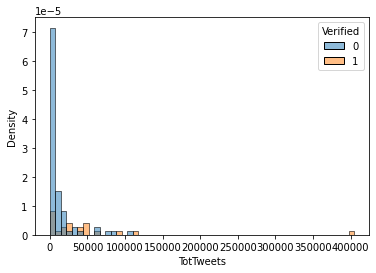

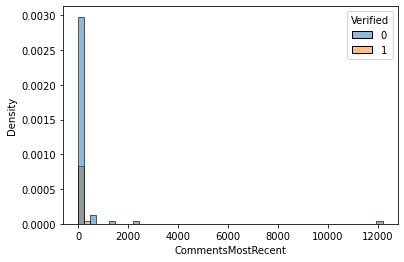

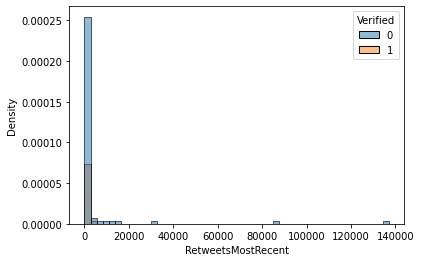

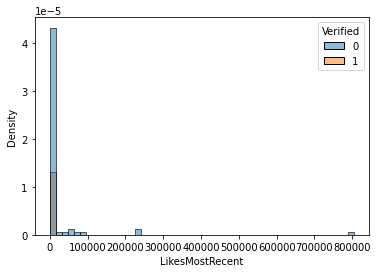

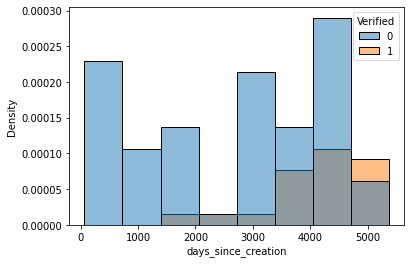

In [12]:
# Create histogram plots for the "Book Tweets" data, using columns of potential interest
fig, ax = plt.subplots()
sns.histplot(data=newdf, x='Following', hue='Verified', stat='density',multiple='layer')

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='Followers', hue='Verified', stat='density',multiple='layer',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='TotTweets', hue='Verified', stat='density',multiple='layer')

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='CommentsMostRecent', hue='Verified', stat='density',multiple='layer',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='RetweetsMostRecent', hue='Verified', stat='density',multiple='layer',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='LikesMostRecent', hue='Verified', stat='density',multiple='layer',bins=50)

fig, ax = plt.subplots()
sns.histplot(data=newdf, x='days_since_creation', hue='Verified', stat='density',multiple='layer')

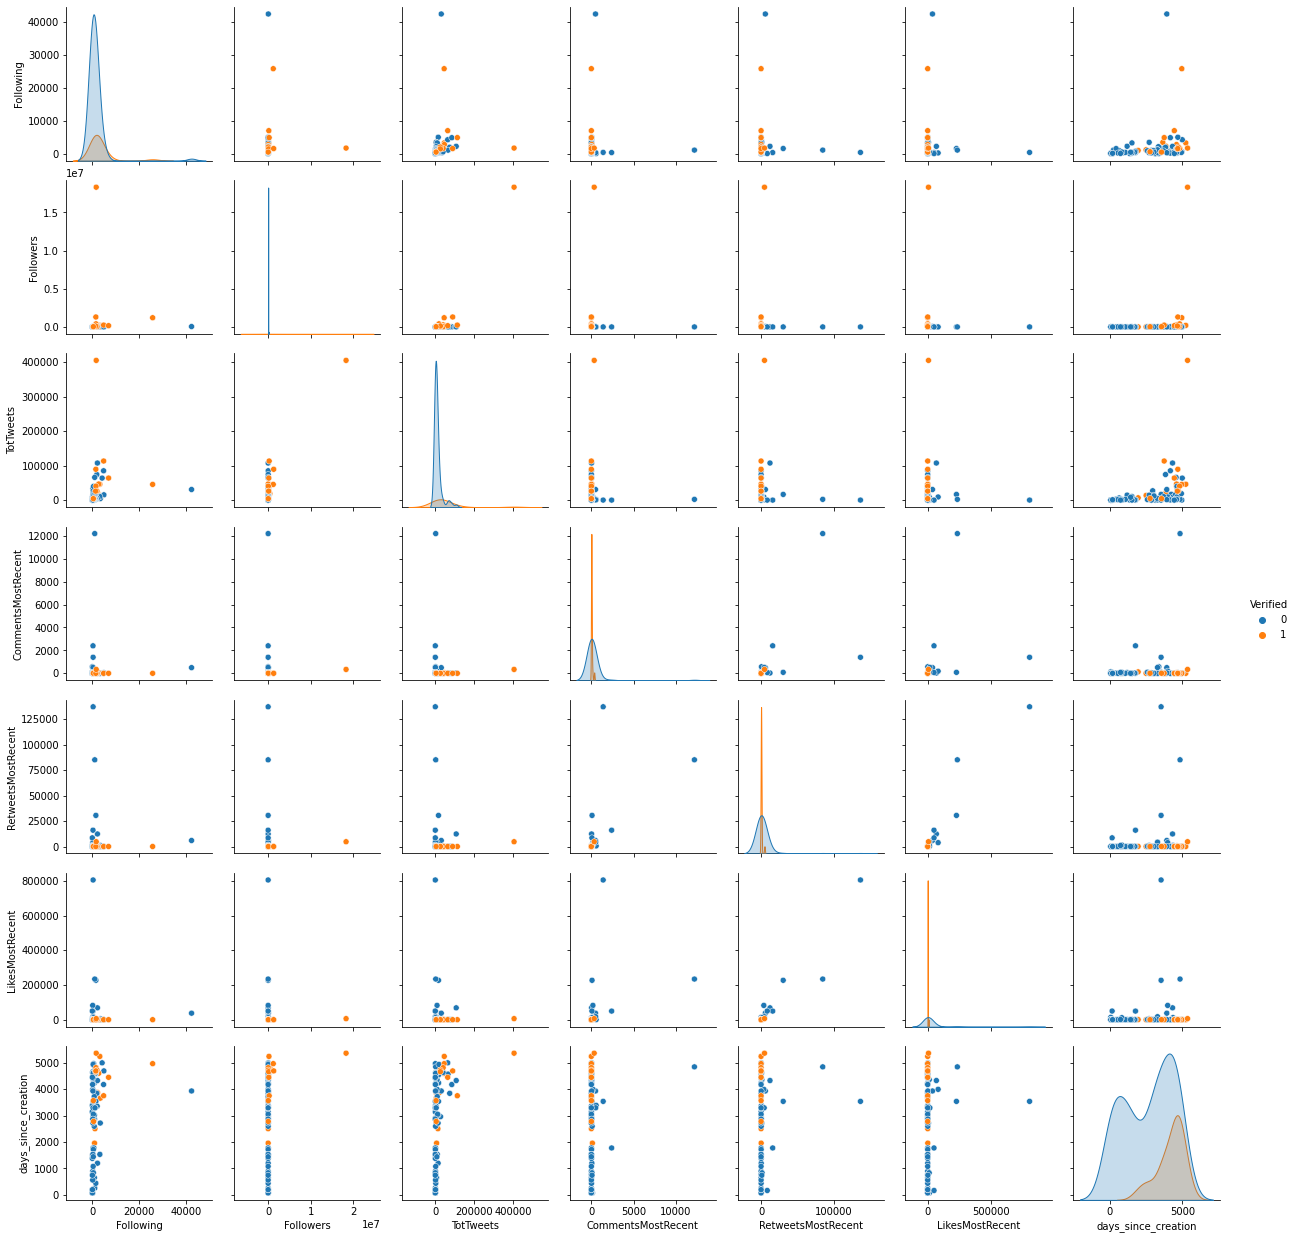

In [13]:
# Create pairwise scatterplots for the "Book Tweets" data, using columns of potential interest
sns.pairplot(data=newdf[['Following', 'Followers', 'TotTweets','CommentsMostRecent', 'RetweetsMostRecent', 'LikesMostRecent','Verified', 'days_since_creation']], hue='Verified')

In [14]:
# Narrow down the "Book Tweets" data to columns of definite interest, 
# to include columns available in both datasets, and to eliminate correlated features
finaldf = newdf[['Following', 'Followers', 'TotTweets', 'Verified', 'days_since_creation']]
finaldf.head()

,Following,Followers,TotTweets,Verified,days_since_creation
0,729,16500,4211,1,4634
1,3273,195200,46000,1,5243
2,1613,263600,40200,1,4603
3,4246,19900,63800,0,4999
4,2287,28300,21300,1,3873


In [15]:
# Summarize the "Book Tweets" data, split by whether the account is verified or not
newdf.groupby('Verified').mean()

,Following,Followers,TotTweets,CommentsMostRecent,RetweetsMostRecent,LikesMostRecent,days_since_creation
Verified,,,,,,,
0,1374.205128,1.954526e+03,10339.000000,240.038462,3983.500000,20818.782051,2668.717949
1,3241.142857,1.071720e+06,49834.142857,26.333333,236.666667,373.333333,4198.380952


In [16]:
# Calculate the dispersion index for the "Book Tweets" data for each feature, by Verified status
(newdf.groupby('Verified').std()**2)/newdf.groupby('Verified').mean()

,Following,Followers,TotTweets,CommentsMostRecent,RetweetsMostRecent,LikesMostRecent,days_since_creation
Verified,,,,,,,
0,16911.663483,1.844754e+04,40145.429368,8277.515731,85547.435553,461312.821502,1072.081548
1,8961.558996,1.466263e+07,149541.596545,224.032911,4421.918592,4848.159464,194.639066


# Models and Predictions

## Model 1 - Logistic Regression 

In [17]:
# Apply SMOTE oversampling to compensate for the fact that the sample size of verified users in the original dataset
# is much smaller than the sample of un-verified users
X = finaldf.loc[:, finaldf.columns != 'Verified']
y = finaldf.loc[:, finaldf.columns == 'Verified']

#SMOTE oversampling
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train) 
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Verified'])

print("length of oversampled data is ",len(os_data_X))
print("Number of not verified in oversampled data",len(os_data_y[os_data_y['Verified']==0]))
print("Number of verified",len(os_data_y[os_data_y['Verified']==1]))
print("Proportion of not verified data in oversampled data is ",len(os_data_y[os_data_y['Verified']==0])/len(os_data_X))
print("Proportion of verified data in oversampled data is ",len(os_data_y[os_data_y['Verified']==1])/len(os_data_X))

length of oversampled data is  110
Number of not verified in oversampled data 55
Number of verified 55
Proportion of not verified data in oversampled data is  0.5
Proportion of verified data in oversampled data is  0.5


In [23]:
# Use RFE for feature selection
data_final_vars=finaldf.columns.values.tolist()
y=['Verified']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False]
[1 1 3 2]


In [24]:
# Model 1 - Logistic Regression, all 4 features
cols = ['Following', 'Followers', 'TotTweets', 'days_since_creation']

X=os_data_X[cols]
y=os_data_y['Verified']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.175851
         Iterations 13
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.746     
Dependent Variable:   Verified         AIC:              46.6871   
Date:                 2021-11-07 12:38 BIC:              57.4890   
No. Observations:     110              Log-Likelihood:   -19.344   
Df Model:             3                LL-Null:          -76.246   
Df Residuals:         106              LLR p-value:      1.6645e-24
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       13.0000                                      
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Following           -0.0008   0.0003 -3.2275 0.0012 -0.0013 -0.0003
Followers            0.0008   0.0002  3.

In [25]:
# Model 2 - Logistic Regression, 3/4 features
# This is the best model

cols = ['Following', 'Followers', 'days_since_creation']

X=os_data_X[cols]
y=os_data_y['Verified']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.179317
         Iterations 13
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.741     
Dependent Variable:   Verified         AIC:              45.4498   
Date:                 2021-11-07 12:38 BIC:              53.5513   
No. Observations:     110              Log-Likelihood:   -19.725   
Df Model:             2                LL-Null:          -76.246   
Df Residuals:         107              LLR p-value:      2.8387e-25
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       13.0000                                      
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Following           -0.0007   0.0002 -3.4457 0.0006 -0.0011 -0.0003
Followers            0.0007   0.0002  3.

In [26]:
# Model 3 - Logistic Regression, 2/4 features
cols = ['Following', 'Followers']

X=os_data_X[cols]
y=os_data_y['Verified']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.321091
         Iterations 12
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.537     
Dependent Variable: Verified         AIC:              74.6401   
Date:               2021-11-07 12:38 BIC:              80.0410   
No. Observations:   110              Log-Likelihood:   -35.320   
Df Model:           1                LL-Null:          -76.246   
Df Residuals:       108              LLR p-value:      1.4664e-19
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     12.0000                                      
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Following     -0.0018    0.0005  -3.4879  0.0005  -0.0028  -0.0008
Followers      0.0004    0.0001   3.7773  0.0002   0.0002   0

In [27]:
# Logistic regression - fitting and scoring the final model
logreg = LogisticRegression()
logreg.fit(os_data_X[['Following','Followers','days_since_creation']], os_data_y.values.ravel())

y_pred = logreg.predict(X_test[['Following','Followers','days_since_creation']])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test[['Following','Followers','days_since_creation']], y_test)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
#22 + 6 correct; 1 + 1 incorrect

Accuracy of logistic regression classifier on test set: 0.93
[[22  1]
 [ 1  6]]


## Predictions of Model 1 - Logistic Regression

In [28]:
# Predictions on the unlabeled dataset
X_new = df2[['following_count','followers_count','days_since_creation']]
X_new = X_new.rename(columns={"following_count": "Following", "followers_count": "Followers"})

y_pred = logreg.predict(X_new)
ydf = pd.DataFrame(y_pred, columns=['Predicted'])

predicted = X_new.copy(deep=True)
predicted.reset_index(drop=True, inplace=True)

predicted = pd.concat([predicted,ydf], ignore_index=True, axis=1)
predicted = predicted.rename(columns={0: "Following", 1: "Followers", 2:"days_since_creation", 3:"Predicted"})
predicted

,Following,Followers,days_since_creation,Predicted
0,0.0,0.0,2494,0
1,4395.0,4155.0,2474,0
2,757.0,438.0,2481,0
3,4728.0,4295.0,2469,0
4,15.0,559.0,2458,0
...,...,...,...,...
292582,9.0,0.0,37,0
292583,143.0,146.0,47,0
292584,3.0,0.0,28,0
292585,1.0,0.0,46,0


In [29]:
# Calculate the mean of each feature, split by whether it was predicted to be a Verified account or not
predicted.groupby('Predicted').mean()

,Following,Followers,days_since_creation
Predicted,,,
0,63.637335,41.552866,657.046190
1,4515.617647,45176.019608,1087.509804


In [30]:
# Calculate the standard deviation of each feature, split by whether it was predicted to be a Verified account or not
predicted.groupby('Predicted').std()

,Following,Followers,days_since_creation
Predicted,,,
0,937.264057,778.867523,446.216660
1,29140.046899,141930.206282,486.028576


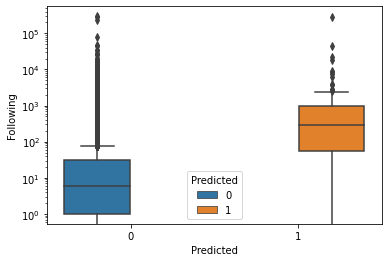

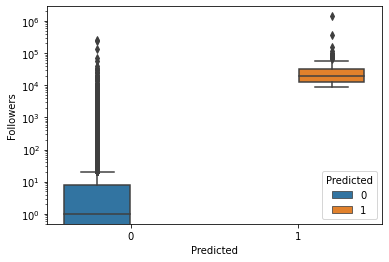

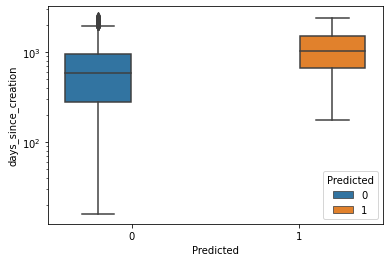

In [31]:
# Create box and whisker plots for the unlabeled user data, 
# split by whether it was predicted to be a Verified account or not
# to visually assess performance
fig, ax = plt.subplots()
sns.boxplot(data=predicted, y='Following', x='Predicted', hue='Predicted')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=predicted, y='Followers', x='Predicted', hue='Predicted')
ax.set_yscale('log')

fig, ax = plt.subplots()
sns.boxplot(data=predicted, y='days_since_creation', x='Predicted', hue='Predicted')
ax.set_yscale('log')

## Model 2 - Poisson Models

### Poisson Mixture Model

C:\Users\Marisa\AppData\Roaming\Python\Python37\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Marisa\miniconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, lam]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1041 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Marisa\AppData\Roaming\Python\Python37\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


posterior predictive variable like's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


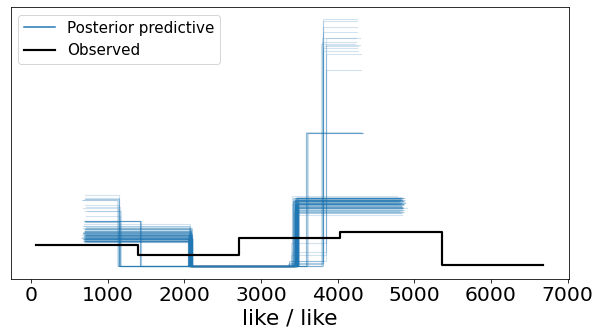

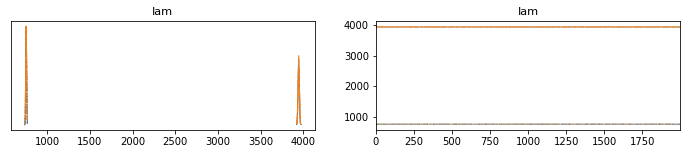

In [45]:
# Applying a mixture of multiple Poisson distributions to each column

X = finaldf.loc[:, finaldf.columns != 'Verified']
y = finaldf.loc[:, finaldf.columns == 'Verified']

# 2-Mixture Poisson distribution
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))  # `shape=(2,)` indicates two mixture components.
    components = pm.Poisson.dist(mu=lam, shape=(2,)) 
    
    w = pm.Dirichlet('w', a=np.ones(2))  # two mixture component weights.
    like = pm.Mixture('like', w=w, comp_dists=components, observed=X['days_since_creation'].values) #Followers, Following, days_since_creation

    trace_n = pm.sample(2000, tune=2000)
    
    y_ppc_n = pm.sample_posterior_predictive(trace_n, 100, model, random_seed=123)
    y_pred_n = az.from_pymc3(trace=trace_n, posterior_predictive=y_ppc_n)
    az.plot_ppc(y_pred_n, figsize=(10, 5), mean=False)
    #plt.xlim(0, 60)
    
    az.plot_trace(trace_n, var_names=['lam']);

### Classic Univariate Poisson

In [ ]:
# Applying a univariate Poisson distribution to each column
with pm.Model() as model_p:
    μ = pm.Uniform('μ', lower=0, upper=60)
    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=μ, observed=X['Followers'].values) #tried with X, os_data_X, and X_new + all of the columns
    trace_p = pm.sample(2000, tune=2000)
    
    az.plot_trace(trace_p);
    
    y_ppc_p = pm.sample_posterior_predictive(trace_p, 100, model_p, random_seed=123)
    y_pred_p = az.from_pymc3(trace=trace_p, posterior_predictive=y_ppc_p)
    az.plot_ppc(y_pred_p, figsize=(10, 5), mean=False);

## Model 3 - Negative Binomial

C:\Users\Marisa\miniconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 265 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Marisa\AppData\Roaming\Python\Python37\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


posterior predictive variable y_est's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


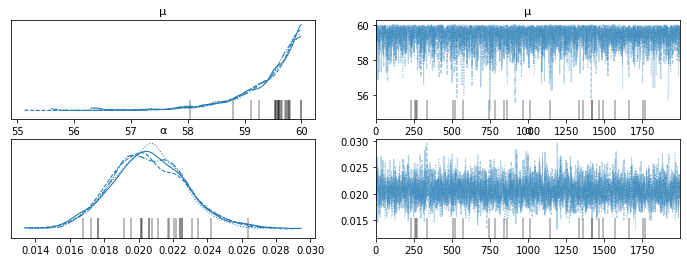

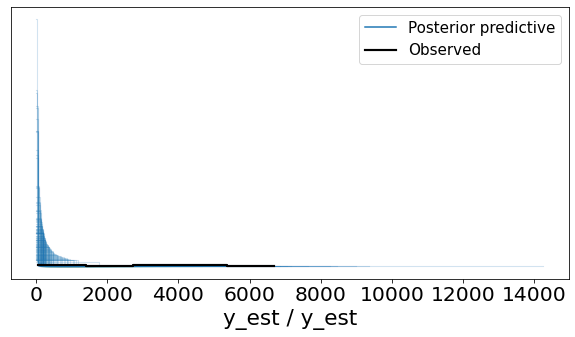

In [54]:
with pm.Model() as model_n:
    
    μ = pm.Uniform('μ', lower=0, upper=60)
    α = pm.Uniform('α', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
    y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=X['days_since_creation'].values)
    
    trace_n = pm.sample(2000, tune=2000)
    
    az.plot_trace(trace_n, var_names=['μ', 'α']);
    
    y_ppc_n = pm.sample_posterior_predictive(trace_n, 100, model_n, random_seed=123)
    y_pred_n = az.from_pymc3(trace=trace_n, posterior_predictive=y_ppc_n)
    az.plot_ppc(y_pred_n, figsize=(10, 5), mean=False);

## Model 3.5 - Hierarchical Bayesian modeling by Verified using a negative binomial distribution

In [84]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
verified_idx = le.fit_transform(finaldf['Verified'])
verified = le.classes_
n_verified = len(verified)

for p in verified:
    with pm.Model() as model_h:
        α = pm.Uniform('α', lower=0, upper=100)
        μ = pm.Uniform('μ', lower=0, upper=60)
        
        data = finaldf[finaldf['Verified']==p]['days_since_creation'].values
        y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
        
        trace_h = pm.sample(2000, tune=2000)
        
        indiv_traces[p] = trace_h

C:\Users\Marisa\miniconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 520 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Marisa\miniconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [μ, α]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 310 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


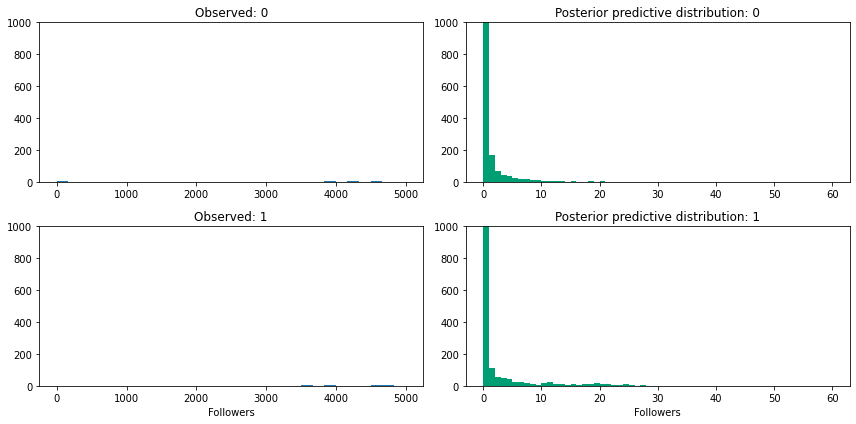

In [85]:
colors = ['#D55E00', '#009E73', '#0072B2', '#348ABD', '#A60628', 
          '#7A68A6', '#467821', '#CC79A7', '#56B4E9', '#F0E442']

fig, axs = plt.subplots(2,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 1000
y_right_max = 1000
#x_lim = 60
ix = [0,1]

for i, j, p in zip([0,1], [0,2], verified[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(finaldf[finaldf['Verified']==p]['days_since_creation'].values, range=[0, 5000], bins=30, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([1,3], [1,3], verified[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, 60], bins=60, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[2].set_xlabel('Followers')
axs[3].set_xlabel('Followers')

plt.tight_layout();